In [1]:
# move workidir to the correct folder
import os
os.chdir("../")

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Custom Libs
from dataset.dataset import Dataset
from model.models.listings_regressor import MLPRegressor, LossAccCallback

In [45]:
# Set up which conlumn to use as a target :
# 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
# 'review_scores_communication', 'review_scores_location', 'review_scores_value',

# Note: not defined for scores

REFERENCE_COlUMN = "review_scores_rating"
BUCKETS = [(0, 4), (4, 4.5), (4.5, 4.8) , (4.8, 5)]
OUTLIERS_LOW = -np.inf
OUTLIERS_HIGH = +np.inf

# REFERENCE_COlUMN = "price"
# BUCKETS = [(50, 100), (100, 200), (300, 400), (400, 500)]
# OUTLIERS_LOW = 50
# OUTLIERS_HIGH = 500

In [46]:
# Experiments Reproducibility
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

Global seed set to 42


42

In [47]:
# Load the precleaned and spearated datset
with open(f'./dataset/train_dataset.pkl', 'rb') as f:
    train_dataset = pd.read_pickle(f)

with open(f'./dataset/test_dataset.pkl', 'rb') as f:
    test_dataset = pd.read_pickle(f)

In [48]:
y_train = train_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_train = train_dataset.getListingsNotEmbeddings()
print("not_embeddings_shape", x_not_embeddings_train.shape)

not_embeddings_shape (5598, 146)


In [49]:
# Apply PCA to non embeddings fields + normalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Note that the PCA and the scaler are kept to be reused in the test
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_train = x_not_embeddings_train.fillna(0)
x_not_embeddings_train_scaled = scaler.fit_transform(x_not_embeddings_train)
x_not_embeddings_train_60 = pca.fit_transform(x_not_embeddings_train_scaled)

In [50]:
#  define X and y for training
X_train = x_not_embeddings_train_60

In [51]:
# Load and prepare Test
y_test = test_dataset.getAllScores()[REFERENCE_COlUMN]
x_not_embeddings_test = test_dataset.getListingsNotEmbeddings()
print("not_embeddings_shape", x_not_embeddings_test.shape)

# PCA for dimensionality reduction
pca = PCA(n_components=60)
scaler = StandardScaler()

x_not_embeddings_test = x_not_embeddings_test.fillna(0)
x_not_embeddings_test_scaled = scaler.fit_transform(x_not_embeddings_test)
x_not_embeddings_test_60 = pca.fit_transform(x_not_embeddings_test_scaled)

X_test = x_not_embeddings_test_60

not_embeddings_shape (1400, 146)


In [52]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Drop nan values based on target conlumn
empty_target_indexes_train = y_train.notna()
X_train = X_train[empty_target_indexes_train]
y_train = y_train[empty_target_indexes_train]

empty_target_indexes_test = y_test.notna()
X_test = X_test[empty_target_indexes_test]
y_test = y_test[empty_target_indexes_test]

## Appling cutout
not_outliers_idx = y_train <= OUTLIERS_HIGH
not_outliers_idx_2 = y_train[y_train <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_train = X_train[not_outliers_idx][not_outliers_idx_2]
y_train = y_train[not_outliers_idx][not_outliers_idx_2]

not_outliers_idx = y_test <= OUTLIERS_HIGH
not_outliers_idx_2 = y_test[y_test <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_test = X_test[not_outliers_idx][not_outliers_idx_2]
y_test = y_test[not_outliers_idx][not_outliers_idx_2]

In [53]:
# Bucket generations
def bucketizie(x):
    for i in range(len(BUCKETS)):
        start, end = BUCKETS[i]
        if (i == 0): 
            if x >= start and  x<=end: return i
        else:
            if x > start and  x<=end: return i
    return len(BUCKETS)

y_train_buckets = [bucketizie(val) for val in y_train]
y_test_buckets = [bucketizie(val) for val in y_test]


In [54]:
# An util function to plot the result of a trained model on the test data
from sklearn import metrics
from lightgbm import LGBMClassifier

def evaluate_and_display(model, x, y):
    y_hat = None
    if  type(LGBMClassifier()) == type(model):
        y_hat = model.predict(x).round()
    else:
        y_hat = model.transform(x).round()

    # print reference
    for i in range(len(buckets)):
        start, end = buckets[i]
        print(f"Bucket {i}-> {start}-{end}")
 
    ## Confusion
    cm = metrics.confusion_matrix(y, y_hat)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    ## ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("AUC:", auc)

    # Accuracy
    print("Accuracy:", metrics.accuracy_score(y, y_hat))

    print(metrics.classification_report(y, y_hat))

In [55]:
model = LGBMClassifier(n_estimators=200, nthread=-1, seed=1729)
model.fit(X_train, y_train_buckets, eval_metric="auc")

/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, nthread=-1, num_parallel_tree=None,
              objective='multi:softprob', ...)

Bucket 0-> 0-4
Bucket 1-> 4-4.5
Bucket 2-> 4.5-4.8
Bucket 3-> 4.8-5


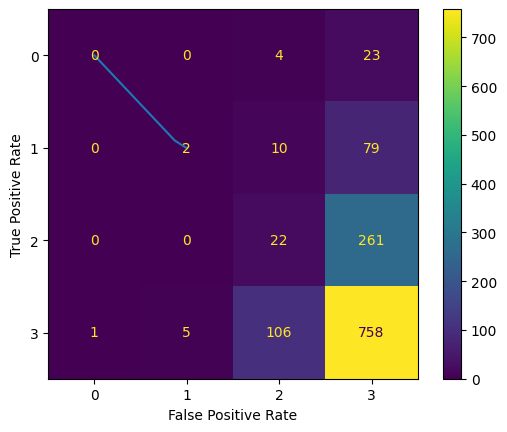

AUC: 0.5262228008183002
Accuracy: 0.6152635719905586


In [56]:
evaluate_and_display(model, X_test, y_test_buckets)